# Import libraries
Jupyter notebook if installed globally can lead to wrong PYTHONPATH, this could lead to error of modul not found while you already installed it. To solve this, we need to install ipykernel and create a separate kernel for our virtual environment. For more detail refer to README.md

```bash
pip install ipykernel
python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"
```

In [1]:
# check if jupyter notebook recognize correct PYTHONPATH
import sys
print(sys.path)

['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/microgix/virenv/course/202409282143_datatalks_ml/project/.env/lib/python3.11/site-packages']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from model_wrapper import TestModel

# Part 1: Data understanding and processing (EDA)

## 1.1 Get to know the data

In [3]:
path = './data.csv'
df = pd.read_csv(path)
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128061 entries, 0 to 128060
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 128061 non-null  float64
 1   Gender              128061 non-null  object 
 2   Education           128061 non-null  int64  
 3   Introversion Score  128061 non-null  float64
 4   Sensing Score       128061 non-null  float64
 5   Thinking Score      128061 non-null  float64
 6   Judging Score       128061 non-null  float64
 7   Interest            128061 non-null  object 
 8   Personality         128061 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 8.8+ MB


(None, (128061, 9))

In [4]:
df.head(10)

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP
5,25.0,Male,0,7.66292,5.758030,1.97014,4.563907,Others,ENFP
6,26.0,Female,1,2.73185,5.898910,3.64832,5.800525,Unknown,INFP
7,27.0,Female,0,5.24958,5.963290,1.16176,5.873350,Sports,ENFJ
8,29.0,Male,0,8.86018,3.681570,7.78505,1.640560,Others,ENTP
9,24.0,Female,0,1.62636,5.160906,7.25476,3.825849,Technology,INTP


This synthetic dataset is designed to explore and predict Myers-Briggs Type Indicator (MBTI) personality types based on a combination of demographic factors, interest areas, and personality scores. It includes 100K+ samples, each representing an individual with various features that contribute to determining their MBTI type. Features included in this dataset are:

**Age**: A continuous variable representing the age of the individual.

**Gender**: A categorical variable indicating the gender of the individual. Possible values are 'Male' and 'Female'.

**Education**: A binary variable, A value of 1 indicates the individual has at least a graduate-level education (or higher), and 0 indicates an undergraduate, high school level or Uneducated.

**Interest**: A categorical variable representing the individual's primary area of interest.

**Introversion Score**: A continuous variable ranging from 0 to 10, representing the individual's tendency toward introversion versus extraversion. Higher scores indicate a greater tendency toward extraversion.

**Sensing Score**: A continuous variable ranging from 0 to 10, representing the individual's preference for sensing versus intuition. Higher scores indicate a preference for sensing.

**Thinking Score**: A continuous variable ranging from 0 to 10, indicating the individual's preference for thinking versus feeling. Higher scores indicate a preference for thinking.

**Judging Score**: A continuous variable ranging from 0 to 10, representing the individual's preference for judging versus perceiving. Higher scores indicate a preference for judging.

**Personality**: Target that contains People Personality Type

The main goal for this project is to use different machine learning models to make prediction related to a person personality based on MBTI score. Since, the target variable contains multiple types of characteristics, its make the problem becomes a multiclass-classification.

## 1.2 Data cleaning and processing

### 1.2.1 Inconsistent column names

In [5]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
print(list(df.columns))

['age', 'gender', 'education', 'introversion_score', 'sensing_score', 'thinking_score', 'judging_score', 'interest', 'personality']


### 1.2.2 Missing values

In [6]:
df.isnull().sum()

age                   0
gender                0
education             0
introversion_score    0
sensing_score         0
thinking_score        0
judging_score         0
interest              0
personality           0
dtype: int64

$\to$ No null values were found. "Unknown" values in 'interest' feature are keept as they are one of a way to handle missing values.

### 1.2.3 Duplicated values

In [7]:
dups_propotion = df.duplicated().sum()/df.shape[0]
dups_propotion

np.float64(0.0)

$\to$ Contains no duplicated values

### 1.2.4 Identify categorical and numerical features

In [8]:
df['education'] = df['education'].astype('object')
cat_f = list(df.select_dtypes(include='object'))
num_f = list(df.drop(columns=cat_f).columns)

cat_f, num_f

(['gender', 'education', 'interest', 'personality'],
 ['age',
  'introversion_score',
  'sensing_score',
  'thinking_score',
  'judging_score'])

In [9]:
# remove target variable
cat_f.remove('personality')

- Target variable: 'personality'
- Categorical features: 'gender', 'interest', 'education'
- Numerical features: 'age', 'introversion_score', 'sensing_score', 'thinking_score', 'judging_score'

### 1.2.5 Target label encoding

In [10]:
le = LabelEncoder()
df.personality = le.fit_transform(df.personality)
df.personality.value_counts()

personality
1     34404
3     24718
9     24711
11    17132
5      4832
0      3883
13     3456
7      3334
8      2919
2      2783
15     2390
10     1920
4       554
6       392
12      371
14      262
Name: count, dtype: int64

In [11]:
# create a dictionary to store mapped values for further investigation
personality_label = dict(map(lambda i, j: (i, j), 
                             range(len(le.classes_)), le.classes_))

personality_label

{0: 'ENFJ',
 1: 'ENFP',
 2: 'ENTJ',
 3: 'ENTP',
 4: 'ESFJ',
 5: 'ESFP',
 6: 'ESTJ',
 7: 'ESTP',
 8: 'INFJ',
 9: 'INFP',
 10: 'INTJ',
 11: 'INTP',
 12: 'ISFJ',
 13: 'ISFP',
 14: 'ISTJ',
 15: 'ISTP'}

### 1.2.6 Feature importance and engineering

In [12]:
for col in cat_f:
    print(df[col].value_counts(), "\n")
    print(f"Mutual info between retention and {col}: {mutual_info_score(df.personality, df[col])}", "\n")

gender
Male      70432
Female    57629
Name: count, dtype: int64 

Mutual info between retention and gender: 0.009695886596935873 

education
0    75408
1    52653
Name: count, dtype: int64 

Mutual info between retention and education: 0.057346709323561486 

interest
Unknown       48835
Arts          25489
Others        21733
Technology    19103
Sports        12901
Name: count, dtype: int64 

Mutual info between retention and interest: 0.011921222195182116 



$\to$ The mutual information of each categorical feature tell us that gender is likely to not produce any useful information in predicting personality. Hence, we will exclude it from the models.

In [13]:
df[num_f].corrwith(df.personality)

age                   0.057918
introversion_score   -0.757621
sensing_score         0.157343
thinking_score        0.191506
judging_score        -0.030594
dtype: float64

$\to$ Based on the correlation between different numerical features, we can see that **introversion_score**, **sensing_score,** and **thinking_score** are considered to have impact on inferencing a person trait. Especially, introversion_score are observed to be the most effected one.

As a result, the following features will be used for model training:

In [14]:
cat_f = [x for x in cat_f if x != 'gender']
num_f = [x for x in num_f if x not in ['age', 'judging_score']]

cat_f, num_f

(['education', 'interest'],
 ['introversion_score', 'sensing_score', 'thinking_score'])

### 1.2.7 Outliers

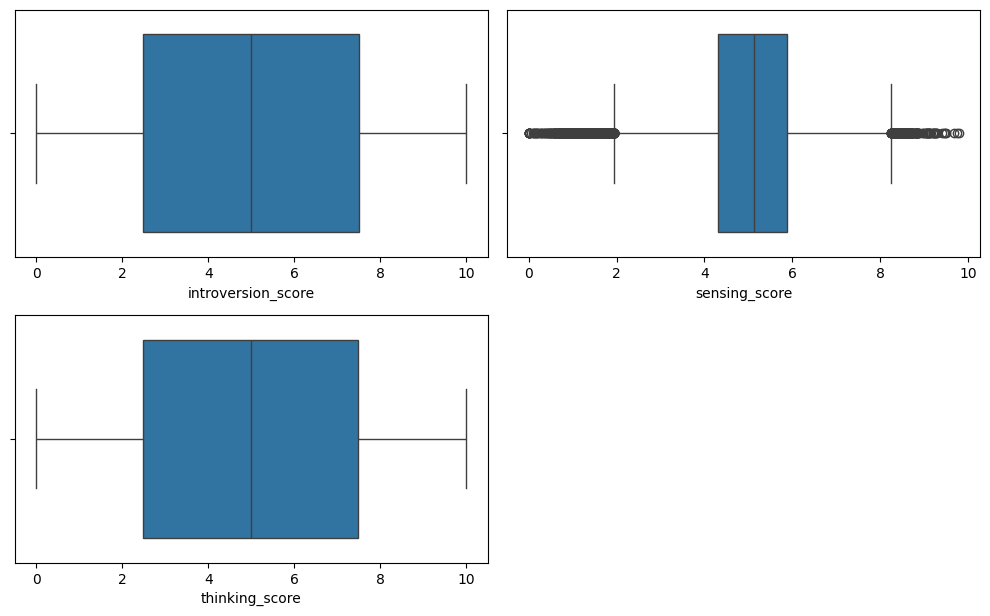

In [15]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(num_f):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

$\to$ From the boxplots, we can observe that **sensing_score** varible contains multiple outilers that need to be addressed. But before we can decide wheter or not to remove outliers, it is important to first investigate the reason behind the existence of these values. And since some models are more sensitive to outliers than other, it also depends on the type of models we choose. Therefore, we will try to deal with outliers only when needed

## 1.3 Validation framework

For this project, i will not follow the validation framework of 60 train, 20 validate, and 20 test. KFold Cross-validation will be used instead.

Guide: [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
```mermaid
graph TD
    A[Parameters] --> B[Cross-validation - KFold]
    J[Features transform] --> B
    D[Dataset] --> E[Full Training data]
    D --> F[Test data]
    E --> B
    B --> G[Best parameters - GridSearch]
    G --> H[Retrained model]
    E --> H
    H --> I[Final evaluation]
    F --> I
```

### 1.3.1 Train and test dataset

In [16]:
# aggregate used features
features = cat_f + num_f
features.append('personality')

# split data to train and test sets
df_full_train, df_test = train_test_split(df[features], 
                                          test_size=0.2, 
                                          random_state=1)
df_train, df_val = train_test_split(df_full_train,
                                   test_size=0.25,
                                   random_state=1)
# reset index
for _ in [df_full_train, df_train, df_val, df_test]:
    _.reset_index(drop=True)

# generalize process of obtaining X and y
def getXy(df, target):
    return df.pop(target), df

# get features and target
y_full_train, X_full_train = getXy(df_full_train, 'personality')
y_train, X_train = getXy(df_train, 'personality')
y_val, X_val = getXy(df_val, 'personality')
y_test, X_test = getXy(df_test, 'personality')

### 1.3.2 Features scaling and encoding
Feature transformation should be performed within the cross-validation process to prevent data leakage and ensure the integrity of model evaluation. However, the following code is provided solely for testing the implementation of the model. 
```mermaid
graph TD
    A[Feature transform] --> B[Cross-validation]
    A --> C[Full Training data]
    A --> D[Test data]
```

In [17]:
train_val_report = TestModel(X_train, y_train,
                             X_val, y_val, 
                             num_f, cat_f)

full_train_test_report = TestModel(X_full_train, y_full_train,
                                   X_test, y_test, 
                                   num_f, cat_f)

### 1.3.3 General validation process
To maintain a consistent workflow across different model evaluations, a wrapper class has been designed. This wrapper will manage the essential steps and streamline the evaluation process, ensuring uniformity and reproducibility.

Document:
- [GridSeachCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
- [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- [Scoring options](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring)

In [45]:
class ParamsTunning:
    def __init__(self, model, param_grid, num_f, cat_f,
                 n_splits=10, n_jobs=-1, n_iter = 50,
                 scoring='roc_auc_ovr_weighted', verbose=0, random_state=42):
        # required params
        self.model = model
        self.num = num_f
        self.cat = cat_f
        self.param_grid = param_grid

        # non-required params
        self.n_splits = n_splits
        self.n_jobs = n_jobs
        self.n_iter = n_iter
        self.scoring = scoring
        self.verbose = verbose
        self.random_state = random_state

        # predefined params
        self.pipeline = None
        self.search = None

    def grid_search(self, X, y):
        """
        Fit the pipeline using grid search cross-validation.
        
        Parameters:
        -----------
        X : pandas DataFrame
            Training features
        y : array-like
            Target variable
        """
        # initialize pipeline
        self.__create_pipeline()

        # create a grid search
        self.search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            cv=self.n_splits,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            verbose=self.verbose
        )

        # fit the model
        self.search.fit(X, y)
        return self.search

    def random_search(self, X, y):
        """
        Fit the pipeline using randommized cross-validation.
        
        Parameters:
        -----------
        X : pandas DataFrame
            Training features
        y : array-like
            Target variable
        """
        # initialize pipeline
        self.__create_pipeline()
    
        # create a grid search
        self.search = RandomizedSearchCV(
            self.pipeline,
            self.param_grid,
            cv=self.n_splits,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            n_iter=self.n_iter,
            random_state=self.random_state,
            verbose=self.verbose
        )
    
        # fit the model
        self.search.fit(X, y)
        return self.search

    def get_result(self):
        df_result = pd.DataFrame(self.search.cv_results_)
        return df_result[['params', 'mean_test_score', 'rank_test_score']]
        
    def __create_pipeline(self):
        """Features transforming"""
        num_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        
        cat_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])

        f_preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, self.num),
                ('cat', cat_transformer, self.cat)
            ]
        )

        self.pipeline = Pipeline([
            ('preprocessor', f_preprocessor),
            ('classifier', self.model)
        ])

---
# Part 2: Model training
List of models used in this project:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting Machines (XGBoot)

---
## 2.1 Logistic Regression
Document: [Scikit-learn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### 2.1.1 Model implementation

In [46]:
logR = LogisticRegression(max_iter=1500, penalty=None)
print(train_val_report.get_result(logR))

0.9663049375165971


$\to$ Evaluation goes here

### 2.1.2 Hyperparameter tunning

#### optional:
- Explain what is regularize and gradient descent
- Choose the best parameter before conduct a KFold validation

In [47]:
paramsT = ParamsTunning(
    model = LogisticRegression(solver='saga', max_iter=1000),
    param_grid = {
        'classifier__C': [0.000001, 0.001, 0.01, 1.0, 1.5]
    },
    num_f = num_f,
    cat_f = cat_f,
)

result = paramsT.grid_search(X_full_train, y_full_train)
print(result.best_params_)

{'classifier__C': 1.5}


$\to$ Evaluation goes here

### 2.1.3 Retrain with test data

In [48]:
logR = LogisticRegression(solver='saga', C=1, max_iter=1000)
print(full_train_test_report.get_result(logR))

0.9666363366646687


$\to$ Evaluation goes here

---
## 2.2 Decision Tree
Document: [Scikit-learn Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

### 2.2.1 Model implementation

In [49]:
decT = DecisionTreeClassifier()
print(train_val_report.get_result(decT))

0.7919277847926157


$\to$ Evaluation goes here

### 2.2.2 Hyperparameter tunning
- Let the tree grows too long can lead to overfitting as the tree will just simply create infinite combinations according to the current observed, hence we need to minimize number of branches as many as possible
- stop criteria:
    - group reach pure state
    - tree reached depth limit (max_depth)
    - group become too small to split (min_samples_leaf) 

In [50]:
paramsT = ParamsTunning(
    model = DecisionTreeClassifier(),
    param_grid = {
        'classifier__max_depth': [6, 7, 8, 9, 10, 15, 20, None],
        'classifier__min_samples_leaf': [1, 2, 5, 10, 15, 20, 100]
    },
    num_f = num_f,
    cat_f = cat_f,
)

result = paramsT.grid_search(X_full_train, y_full_train)
print(result.best_params_)

{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 100}


### 2.2.3 Retrain with test data

In [51]:
decT = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
print(full_train_test_report.get_result(decT))

0.966141950754417


$\to$ Evaluation goes here

---
## 2.3 Random Forest

### 2.3.1 Model implementation

In [52]:
ranF = RandomForestClassifier(n_estimators=10, random_state=42)
print(train_val_report.get_result(ranF))

0.9355972923339563


### 2.3.2 Hyperparameter tunning

In [53]:
ranFT = ParamsTunning(
    model = RandomForestClassifier(random_state=42),
    param_grid = {
        'classifier__max_depth': [5, 10, 15],
        'classifier__n_estimators': [x for x in range(50, 201, 10)]
    },
    num_f = num_f,
    cat_f = cat_f,
    n_splits = 5
)

ranFT.grid_search(X_train, y_train)

/home/microgix/virenv/course/202409282143_datatalks_ml/project/.env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['introversion_score',
                                                                          'sensing_score',
                                                                          'thinking_score']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['education',
                                                                          'interest'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 15],
                         'classifier__n_estimators': [50, 60, 70, 80, 90, 100,
                                                      110, 120, 130, 140, 150,
                                                      160, 170, 180, 190,
                                                      200]},
             scoring='roc_auc_ovr_weighted')

In [54]:
df_report = ranFT.get_result()
df_report.sort_values(by='rank_test_score').reset_index().head().params[0]

{'classifier__max_depth': 10, 'classifier__n_estimators': 160}

In [55]:
ranFT = ParamsTunning(
    model = RandomForestClassifier(max_depth=10,
                                   n_estimators=160,
                                   random_state=42),
    param_grid = {
        'classifier__min_samples_leaf': [1, 3, 5, 10, 50],
    },
    num_f = num_f,
    cat_f = cat_f,
    n_splits = 5
)

ranFT.grid_search(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['introversion_score',
                                                                          'sensing_score',
                                                                          'thinking_score']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['education',
                                                                          'interest'])])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=160,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__min_samples_leaf': [1, 3, 5, 10, 50]},
             scoring='roc_auc_ovr_weighted')

In [56]:
df_report = paramsT.get_result()
df_report.sort_values(by='rank_test_score').reset_index().head().params[0]

{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 100}

### 2.3.3 Retrain with test data

In [57]:
ranF = RandomForestClassifier(max_depth=10, min_samples_leaf=50,
                              n_estimators=160, random_state=42)
print(full_train_test_report.get_result(ranF))

0.9709593213682409


$\to$ Evaluation goes here

---
## 2.4 Gradient Tree Boosting (XGBoost)
This course cover the implementation of Gradient Tree Boosting by usuing `xgboost` package. However, in this project i will go with `HistGradientTreeClassifier` from scikit-learn. I will try to cover its advantage and disadvantage comparing with xgboost. Also, consistency is another reason why i consider this.

Document: [HistGradientTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)

### 2.4.1 Model implementation

In [58]:
hgb = HistGradientBoostingClassifier(random_state=42)
print(train_val_report.get_result(hgb))

0.9635330277159777


$\to$ Evaluation goes here

### 2.4.2 Hyperparameter tunning
Parameters:
- `learning rate`
- `max_depth`
- `min_samples_leaf`

In [59]:
paramsT = ParamsTunning(
    model = HistGradientBoostingClassifier(max_iter=100, random_state=42),
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 0.3, 0.5, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 10, 20],
        'classifier__min_samples_leaf': [3, 5, 10, 50]
    },
    num_f = num_f,
    cat_f = cat_f,
    n_splits = 5
)

paramsT.grid_search(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['introversion_score',
                                                                          'sensing_score',
                                                                          'thinking_score']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['education',
                                                                          'interest'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.3, 0.5, 0.8,
                                                       1.0],
                         'classifier__max_depth': [3, 4, 10, 20],
                         'classifier__min_samples_leaf': [3, 5, 10, 50]},
             scoring='roc_auc_ovr_weighted')

In [60]:
df_report = paramsT.get_result()
df_report = df_report.sort_values(by='rank_test_score').reset_index()
df_report.params[0]

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 3}

$\to$ Evaluation goes here

### 2.4.3 Retrain with test data

In [19]:
hgb = HistGradientBoostingClassifier(max_iter=100, random_state=42,
                                    learning_rate=0.1, max_depth=3, min_samples_leaf=3)
print(full_train_test_report.get_result(hgb))

0.9708967768527763


---
# Part 3: Deployment
This include:
- Save models to binary files
- Export notebook to python script

## 3.1 Select a model
Say something

## 3.2 Save model

In [20]:
with open('model.bin', 'wb') as f_out:
    pickle.dump((full_train_test_report, hgb), f_out)

---
# Part 4: Testing

In [14]:
import requests
url = 'http://0.0.0.0:8185/predict'

In [15]:
visitor = {
    'age': 25.0,
    'gender': 'Female',
    'education': 0,
    'introversion_score': 8.86186,
    'sensing_score': 4.5106399620302735,
    'thinking_score': 2.80342,
    'judging_score': 4.77769000642399,
    'interest': 'Others',
}

In [16]:
requests.post(url, json=visitor).json()

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8185): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe512248950>: Failed to establish a new connection: [Errno 111] Connection refused'))